##**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

##**Aprendizaje Automático Profundo (Deep Learning)**

*Edición 2022*


**Integrantes:**


*   Abdala, Agustin
*   Acosta, Martín
*   Gonzalo Argüello
*   Matias Mengual
*   Mateo Ramos



----



## Ejercicio:
Implementar una red neuronal que asigne una categoría dado un título.
Para este práctico se puede usar cualquier tipo de red neuronal. Les que hagan solo la primera mitad de la materia,
implementarán un MLP. Quienes cursan la materia completa, deberían implementar algo más complejo, usando CNNs,
RNNs o Transformers.

Algunas consideraciones a tener en cuenta para estructurar el trabajo:



1.   Hacer un preprocesamiento de los datos (¿Cómo vamos a representar los datos de entrada y las categorías?).
2.   Tener un manejador del dataset (alguna clase o función que nos divida los datos en batches).
3.   Crear una clase para el modelo que se pueda instanciar con diferentes hiperparámetros
4.   Hacer logs de entrenamiento (reportar tiempo transcurrido, iteraciones/s, loss, accuracy, etc.). Usar MLFlow.
5.   Hacer un gráfico de la función de loss a lo largo de las epochs. MLFlow también puede generar la gráfica.
6.   Reportar performance en el conjunto de test con el mejor modelo entrenado. La métrica para reportar será balanced accuracy (Macro-recall).

##Descarga de datos Meli Challenge 2019

In [ ]:

#CORRER UNA VEZ
!mkdir ./data
!curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/glove.6B.50d.txt.gz -o ./data/glove.6B.50d.txt.gz
!curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/meli-challenge-2019.tar.bz2 -o ./data/meli-challenge-2019.tar.bz2
!tar jxvf ./data/meli-challenge-2019.tar.bz2 -C ./data/
!pip install mlflow
!pip install --upgrade gensim


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.9M  100 65.9M    0     0  11.0M      0  0:00:05  0:00:05 --:--:-- 14.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  945M  100  945M    0     0  16.5M      0  0:00:56  0:00:56 --:--:-- 17.0M
meli-challenge-2019/
meli-challenge-2019/spanish.test.jsonl.gz
meli-challenge-2019/portuguese.validation.jsonl.gz
meli-challenge-2019/portuguese.train.jsonl.gz
meli-challenge-2019/spanish.train.jsonl.gz
meli-challenge-2019/spanish_token_to_index.json.gz
meli-challenge-2019/portuguese_token_to_index.json.gz
meli-challenge-2019/spanish.validation.jsonl.gz
meli-challenge-2019/portuguese.test.jsonl.gz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████

## Librerías

In [ ]:
import csv
import functools
import gzip
import pandas as pd
import json
import tempfile
import gzip
import json
import tqdm
import mlflow
import torch.nn.functional as F
from sklearn.metrics import balanced_accuracy_score

from gensim import corpora
from gensim.parsing import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from tqdm.notebook import tqdm, trange
from gensim.models import KeyedVectors
from torch.utils.data import Dataset, DataLoader, IterableDataset
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import classification_report

## Dataset

Para la ingesta del dataset utilizaremos un chunksize el cual nos permitira realizar ingesta cada 10000 datos dado el gran volumen de datos

####Train Set

In [ ]:
train_df = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.train.jsonl.gz', lines=True, chunksize=100000)], ignore_index=True)
train_df

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,reliable,Casita Muñecas Barbies Pintadas,DOLLHOUSES,train,"[casita, muñecas, barbies, pintadas]","[50001, 2, 50000, 3]",0,632,4895280
1,spanish,unreliable,Neceser Cromado Holográfico,TOILETRY_BAGS,train,"[neceser, cromado, holográfico]","[6, 4, 5]",1,632,4895280
2,spanish,unreliable,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS,train,"[funda, asiento, medida, chevrolet]","[9, 7, 10, 8]",2,632,4895280
3,spanish,unreliable,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS,train,"[embrague, ford, focus, one]","[11, 13, 12, 14]",3,632,4895280
4,spanish,unreliable,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES,train,"[bateria, panasonic, dmwbcf, lumix, dmc, fxn, ...","[15, 19, 17, 18, 16, 1, 1, 1]",4,632,4895280
...,...,...,...,...,...,...,...,...,...,...
4895275,spanish,unreliable,Kit 2 Bieletas Delanteras Monroe Vw Fox 1.6 - ...,SWAY_BAR_LINKS,train,"[kit, bieletas, delanteras, monroe, fox]","[521, 4798, 9027, 3896, 593]",28,632,4895280
4895276,spanish,unreliable,Organo Teclado Casio Ct-x5000 61 Teclas Profes...,MUSICAL_KEYBOARDS,train,"[organo, teclado, casio, teclas, profesional, ...","[104, 30, 101, 6035, 962, 769]",24,632,4895280
4895277,spanish,reliable,Mochila Impermeable Belvento Fausto,BACKPACKS,train,"[mochila, impermeable, belvento, fausto]","[337, 2560, 1, 4711]",74,632,4895280
4895278,spanish,unreliable,Mochila San Lorenzo De Espalda 16p Sl001,BACKPACKS,train,"[mochila, san, lorenzo, espalda]","[337, 2125, 4974, 335]",74,632,4895280


Dados los tiempos y el poder de procesamiento disponible utilizaremos 30000 datos de los 4895280 disponibles.
Se estima que aumentando este valor se mejorarian las metricas de los modelos propuestos

In [ ]:
filtro = train_df.index < 30000
train_df = train_df[filtro]
train_df

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,reliable,Casita Muñecas Barbies Pintadas,DOLLHOUSES,train,"[casita, muñecas, barbies, pintadas]","[50001, 2, 50000, 3]",0,632,4895280
1,spanish,unreliable,Neceser Cromado Holográfico,TOILETRY_BAGS,train,"[neceser, cromado, holográfico]","[6, 4, 5]",1,632,4895280
2,spanish,unreliable,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS,train,"[funda, asiento, medida, chevrolet]","[9, 7, 10, 8]",2,632,4895280
3,spanish,unreliable,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS,train,"[embrague, ford, focus, one]","[11, 13, 12, 14]",3,632,4895280
4,spanish,unreliable,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES,train,"[bateria, panasonic, dmwbcf, lumix, dmc, fxn, ...","[15, 19, 17, 18, 16, 1, 1, 1]",4,632,4895280
...,...,...,...,...,...,...,...,...,...,...
29995,spanish,reliable,Controlador Para Djs Apogee Di,DJ_CONTROLLERS,train,"[controlador, djs, apogee]","[642, 14163, 5777]",530,632,4895280
29996,spanish,unreliable,Espumante Las Perdices Extra Brut Charmat Oferta!,CHAMPAGNES,train,"[espumante, perdices, extra, brut, charmat, of...","[4260, 21966, 597, 4259, 21965, 446]",225,632,4895280
29997,spanish,unreliable,Pollera Paisana Celeste Verde 90 Cms,SKIRTS,train,"[pollera, paisana, celeste, verde, cms]","[1922, 21967, 2067, 1707, 4541]",350,632,4895280
29998,spanish,unreliable,Rompeviento De La Selección Argentina 2019 De ...,FOOTBALL_JACKETS,train,"[rompeviento, selección, argentina, utileria]","[8427, 8962, 379, 6220]",39,632,4895280


In [ ]:
train_df.drop(['language','label_quality','split', 'tokenized_title', 'data', 'target', 'n_labels', 'size'], inplace=True, axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Se quitaran columnas que no se consideran necesarias para realizar la clasificación

In [ ]:
train_df

,title,category
0,Casita Muñecas Barbies Pintadas,DOLLHOUSES
1,Neceser Cromado Holográfico,TOILETRY_BAGS
2,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS
3,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS
4,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES
...,...,...
29995,Controlador Para Djs Apogee Di,DJ_CONTROLLERS
29996,Espumante Las Perdices Extra Brut Charmat Oferta!,CHAMPAGNES
29997,Pollera Paisana Celeste Verde 90 Cms,SKIRTS
29998,Rompeviento De La Selección Argentina 2019 De ...,FOOTBALL_JACKETS


####Test Set

In [ ]:
test_df = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.validation.jsonl.gz', lines=True, chunksize=100000)], ignore_index=True)
test_df

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,unreliable,Metal Biela Dw10 Hdi 2.0,ENGINE_BEARINGS,validation,"[metal, biela, hdi]","[457, 1480, 3450]",88,632,1223820
1,spanish,unreliable,Repuestos Martillo Rotoprcutor Bosch Gshsce Po...,ELECTRIC_DEMOLITION_HAMMERS,validation,"[repuestos, martillo, rotoprcutor, bosch, gshs...","[3119, 892, 1, 767, 1, 9337]",174,632,1223820
2,spanish,unreliable,Pesca Caña Pejerrey Colony Brava 3m Fibra De V...,FISHING_RODS,validation,"[pesca, caña, pejerrey, colony, brava, fibra, ...","[700, 990, 2057, 3990, 3670, 1737, 1153, 6568]",313,632,1223820
3,spanish,unreliable,Porcelanato Abitare Be 20x120 Cm. Ceramica Por...,PORCELAIN_TILES,validation,"[porcelanato, abitare, ceramica, portinari]","[2722, 4404, 1406, 4405]",427,632,1223820
4,spanish,unreliable,Reconstruction Semi Di Lino Alfaparf Shampoo 1...,HAIR_SHAMPOOS_AND_CONDITIONERS,validation,"[reconstruction, semi, lino, alfaparf, shampoo]","[1, 3365, 7502, 10919, 849]",194,632,1223820
...,...,...,...,...,...,...,...,...,...,...
1223815,spanish,unreliable,Injen Sp1480blk Sistema Admisión De Aire ( Acu...,AUTOMOTIVE_AIR_FILTERS,validation,"[injen, spblk, sistema, admisión, aire, acura,...","[49558, 1, 947, 8111, 591, 8098, 4474]",471,632,1223820
1223816,spanish,unreliable,Peugeot 106,CLASSIC_CARS,validation,[peugeot],[1132],5,632,1223820
1223817,spanish,unreliable,Kit Portero Eléctrico P/5 Dptos Commax,ELECTRONIC_ENTRANCE_INTERCOMS,validation,"[kit, portero, eléctrico, dptos, commax]","[521, 552, 495, 45123, 549]",114,632,1223820
1223818,spanish,reliable,Pedigree Cachorros 21kg Envío Gratis San Isidr...,CATS_AND_DOGS_FOODS,validation,"[pedigree, cachorros, envío, gratis, san, isid...","[4683, 3490, 1465, 1429, 2125, 11856, 11857]",178,632,1223820


In [ ]:
filtro = test_df.index < 30000
test_df = test_df[filtro]
test_df

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,unreliable,Metal Biela Dw10 Hdi 2.0,ENGINE_BEARINGS,validation,"[metal, biela, hdi]","[457, 1480, 3450]",88,632,1223820
1,spanish,unreliable,Repuestos Martillo Rotoprcutor Bosch Gshsce Po...,ELECTRIC_DEMOLITION_HAMMERS,validation,"[repuestos, martillo, rotoprcutor, bosch, gshs...","[3119, 892, 1, 767, 1, 9337]",174,632,1223820
2,spanish,unreliable,Pesca Caña Pejerrey Colony Brava 3m Fibra De V...,FISHING_RODS,validation,"[pesca, caña, pejerrey, colony, brava, fibra, ...","[700, 990, 2057, 3990, 3670, 1737, 1153, 6568]",313,632,1223820
3,spanish,unreliable,Porcelanato Abitare Be 20x120 Cm. Ceramica Por...,PORCELAIN_TILES,validation,"[porcelanato, abitare, ceramica, portinari]","[2722, 4404, 1406, 4405]",427,632,1223820
4,spanish,unreliable,Reconstruction Semi Di Lino Alfaparf Shampoo 1...,HAIR_SHAMPOOS_AND_CONDITIONERS,validation,"[reconstruction, semi, lino, alfaparf, shampoo]","[1, 3365, 7502, 10919, 849]",194,632,1223820
...,...,...,...,...,...,...,...,...,...,...
29995,spanish,unreliable,Chicco Nextfit Zip Privata Butaca,BABY_CAR_SEATS,validation,"[chicco, nextfit, zip, privata, butaca]","[1523, 38560, 6518, 1, 1628]",285,632,1223820
29996,spanish,unreliable,Batería Gel 12v 12ah Vision Para Ups Emerson A...,UPS_BATTERIES,validation,"[batería, gel, vision, ups, emerson, apc, eato...","[177, 113, 4123, 1447, 36283, 10438, 12535, 1446]",277,632,1223820
29997,spanish,unreliable,Bulldog Frances Machos Fca,PUREBRED_DOGS,validation,"[bulldog, frances, machos, fca]","[5379, 4160, 2519, 5380]",243,632,1223820
29998,spanish,unreliable,Filtro Aire Mann Vw New Beetle 2.0 Aeg (desde ...,AUTOMOTIVE_AIR_FILTERS,validation,"[filtro, aire, mann, new, beetle, aeg]","[1575, 591, 3406, 2302, 2405, 26816]",471,632,1223820


In [ ]:
test_df.drop(['language','label_quality','split', 'tokenized_title', 'data', 'target', 'n_labels', 'size'], inplace=True, axis=1)
test_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,title,category
0,Metal Biela Dw10 Hdi 2.0,ENGINE_BEARINGS
1,Repuestos Martillo Rotoprcutor Bosch Gshsce Po...,ELECTRIC_DEMOLITION_HAMMERS
2,Pesca Caña Pejerrey Colony Brava 3m Fibra De V...,FISHING_RODS
3,Porcelanato Abitare Be 20x120 Cm. Ceramica Por...,PORCELAIN_TILES
4,Reconstruction Semi Di Lino Alfaparf Shampoo 1...,HAIR_SHAMPOOS_AND_CONDITIONERS


## Preprocesamiento

En este caso vamos a utilizar un sólo módulo para transformar los datos. Este se encargará de preprocesar el texto (i.e. normalizarlo) y transformará las palabras en índices de un diccionario para luego poder pasar una secuencia de palabras para buscar en la matriz de embeddings.

In [ ]:
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        # https://radimrehurek.com/gensim/corpora/dictionary.html
        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )
        # Filter the dictionary with extremos words
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html?highlight=filter_extrem
 #       self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        
        # Make the indices continuous after some words have been removed
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.compactify.html
        self.dictionary.compactify()
                
        self.dictionary.patch_with_special_tokens({
          "[PAD]": 0, #The padding token
          "[UNK]": 1  # The unknown token
        })

        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}


    def _preprocess_string(self, string):
        # https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string:~:text=gensim.parsing.preprocessing.preprocess_string
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
      # https://radimrehurek.com/gensim/corpora/dictionary.html#:~:text=doc2idx(document,via%20unknown_word_index.
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

In [ ]:
class MyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, "title"],
            "target": self.dataset.loc[item, "category"]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item

In [ ]:
preprocess_train = RawDataProcessor(train_df)
train_dataset = MyDataset(train_df, transform=preprocess_train)

preprocess_test = RawDataProcessor(test_df)
test_dataset = MyDataset(test_df, transform=preprocess_test)

print(f"Datasets loaded with {len(train_dataset)} training elements and {len(test_dataset)} test elements")
print(f"Sample train element:\n{train_dataset[0]}")

Datasets loaded with 30000 training elements and 30000 test elements
Sample train element:
{'data': [27344, 2, 27343, 3], 'target': 188}


In [ ]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }

In [ ]:
pad_sequences = PadSequences()

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False, num_workers=0)

## Experimento de MLflow - MyMLP

Para el mismo se propone una red con una con tres capas.

In [ ]:
class MyMLP(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()

        self.embeddings = nn.Embedding(len(dictionary), 50, 0) 

        self.hidden1 = nn.Linear(vector_size, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 632)
        self.vector_size = vector_size
    
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        #print("1---", x.shape)
        x = self.output(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
mlflow.set_experiment("Experiment_01_MLP")
EPOCHS = 3
with mlflow.start_run():
    mlflow.log_param("model_name", "mlp")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 50,
        "hidden1_size": 128,
        "hidden2_size": 128
    })
    model = MyMLP("./data/glove.6B.50d.txt.gz", preprocess_train.dictionary, 50, True)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    for epoch in range(EPOCHS):
        model.to(device)
        running_loss = []
        y_true = []
        y_pred = []

        for idx, batch in enumerate(tqdm(train_loader)):
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            optimizer.zero_grad()
            inputs, labels = batch["data"], batch["target"]
            output = model(batch["data"])
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            loss_value = loss(output, batch["target"].squeeze().long())
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())        
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("Train Balanced Accuracy", balanced_accuracy_score(y_true, y_pred), epoch)

       
        model.eval()
        running_loss = []
        y_true = []
        y_pred = []
        targets = []
        predictions = []
        for idx, batch in enumerate(tqdm(train_loader)):
            inputs, labels = batch["data"], batch["target"]
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            output = model(batch["data"])
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            running_loss.append(
                loss(output, batch["target"].squeeze().long()).item()
            )
            targets.extend(batch["target"].cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        mlflow.log_metric("test_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("Test Balanced Accuracy", balanced_accuracy_score(y_true, y_pred), epoch)


    with tempfile.TemporaryDirectory() as tmpdirname:
        targets = []
        predictions = []
        for idx, batch in enumerate(tqdm(train_loader)):
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            output = model(batch["data"])
            targets.extend(batch["target"].cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(
            f"{tmpdirname}/predictions.csv.gz", index=False
        )
        mlflow.log_artifact(f"{tmpdirname}/predictions.csv.gz")
       

2022/10/05 17:48:35 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_01_MLP' does not exist. Creating a new experiment.


  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

####Curva Loss

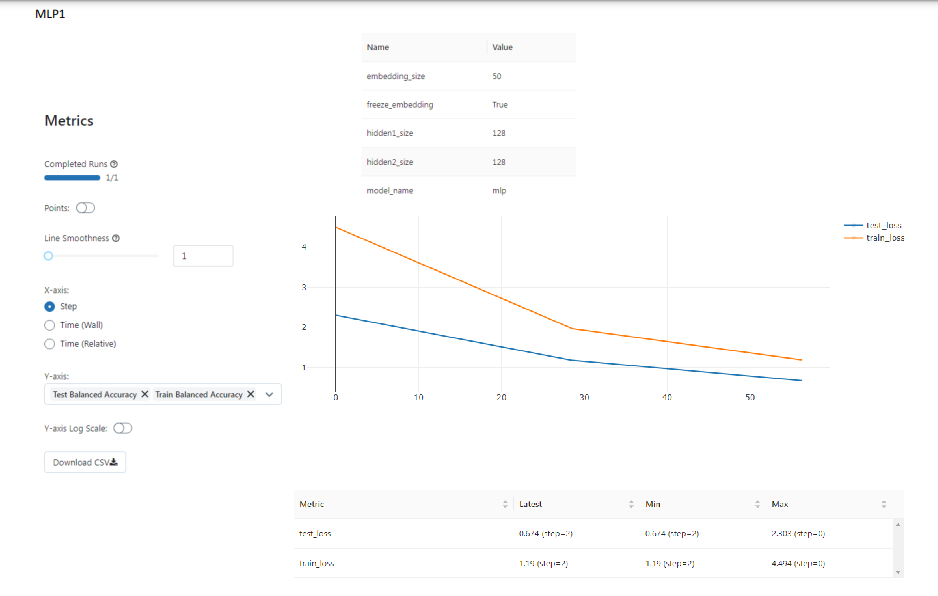

####Curva metrica (Balanced Accuracy)


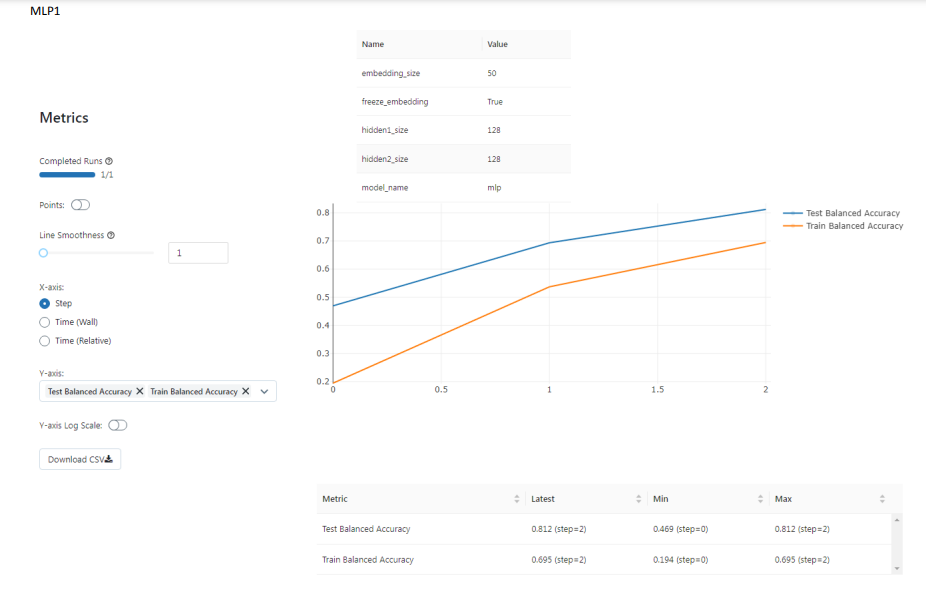

## Experimento de MLflow - MyMLP2

Para el mismo se propone una red con una con tres capas, se cambian las salidas de las capas a 256

In [ ]:
class MyMLP2(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()

        self.embeddings = nn.Embedding(len(dictionary), 50, 0) 

        self.hidden1 = nn.Linear(vector_size, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.output = nn.Linear(256, 632)
        self.vector_size = vector_size


mlflow.set_experiment("Experiment_02_MLP")
EPOCHS = 3
with mlflow.start_run():
    mlflow.log_param("model_name", "mlp")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 50,
        "hidden1_size": 256,
        "hidden2_size": 256
    })
    model = MyMLP("./data/glove.6B.50d.txt.gz", preprocess_train.dictionary, 50, True)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    for epoch in range(EPOCHS):
        model.to(device)
        running_loss = []
        y_true = []
        y_pred = []

        for idx, batch in enumerate(tqdm(train_loader)):
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            optimizer.zero_grad()
            inputs, labels = batch["data"], batch["target"]
            output = model(batch["data"])
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            loss_value = loss(output, batch["target"].squeeze().long())
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())        
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("Train Balanced Accuracy", balanced_accuracy_score(y_true, y_pred), epoch)

       
        model.eval()
        running_loss = []
        y_true = []
        y_pred = []
        targets = []
        predictions = []
        for idx, batch in enumerate(tqdm(train_loader)):
            inputs, labels = batch["data"], batch["target"]
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            output = model(batch["data"])
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            running_loss.append(
                loss(output, batch["target"].squeeze().long()).item()
            )
            targets.extend(batch["target"].cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        mlflow.log_metric("test_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("Test Balanced Accuracy", balanced_accuracy_score(y_true, y_pred), epoch)


    with tempfile.TemporaryDirectory() as tmpdirname:
        targets = []
        predictions = []
        for idx, batch in enumerate(tqdm(train_loader)):
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            output = model(batch["data"])
            targets.extend(batch["target"].cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(
            f"{tmpdirname}/predictions.csv.gz", index=False
        )
        mlflow.log_artifact(f"{tmpdirname}/predictions.csv.gz")
       

2022/10/05 17:53:15 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_02_MLP' does not exist. Creating a new experiment.


  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

####Curva Loss

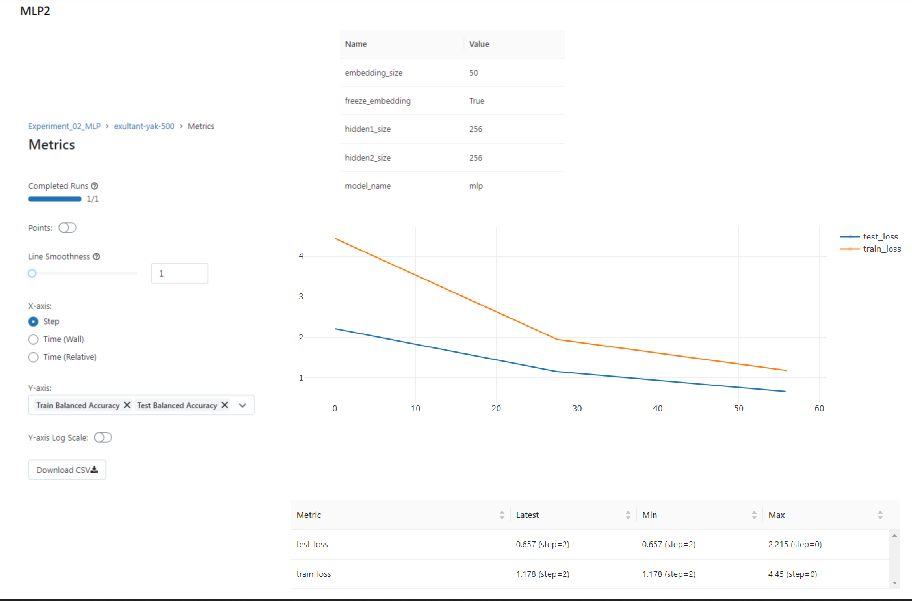

####Curva metrica (Balanced Accuracy)


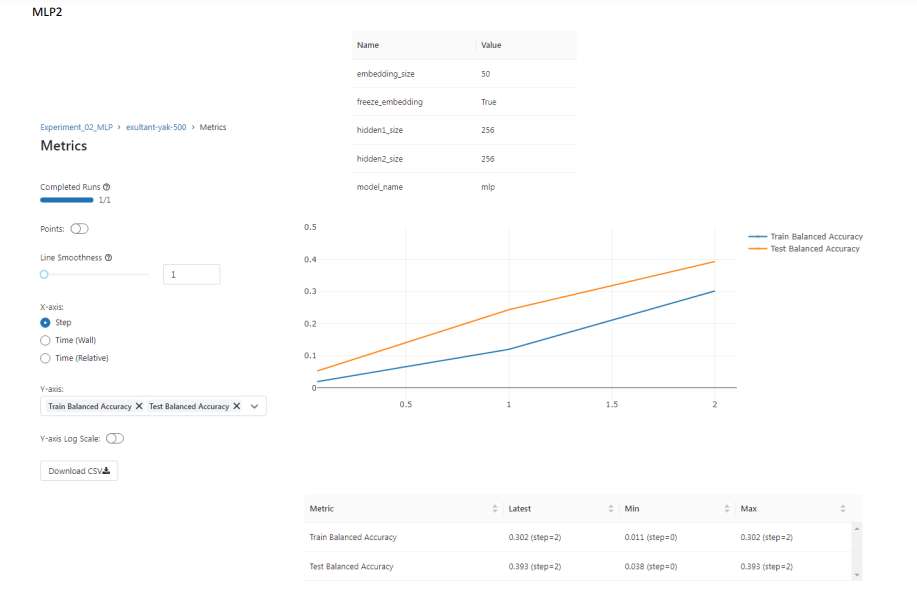

In [ ]:
!pip install pyngrok --quiet
!ngrok config add-authtoken 2FUCfvrAcm0MBdORxrIXshzwJN9_83QeBD6hRq6JsVERoSAnt

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2FUCfvrAcm0MBdORxrIXshzwJN9_83QeBD6hRq6JsVERoSAnt"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

NAME:
   ngrok - tunnel local ports to public URLs and inspect traffic

DESCRIPTION:
    ngrok exposes local networked services behinds NATs and firewalls to the
    public internet over a secure tunnel. Share local websites, build/test
    webhook consumers and self-host personal services.
    Detailed help for each command is available with 'ngrok help <command>'.
    Open http://localhost:4040 for ngrok's web interface to inspect traffic.

EXAMPLES:
    ngrok http 80                    # secure public URL for port 80 web server
    ngrok http -subdomain=baz 8080   # port 8080 available at baz.ngrok.io
    ngrok http foo.dev:80            # tunnel to host:port instead of localhost
    ngrok http https://localhost     # expose a local https server
    ngrok tcp 22                     # tunnel arbitrary TCP traffic to port 22
    ngrok tls -hostname=foo.com 443  # TLS traffic for foo.com to port 443
    ngrok start foo bar baz          # start tunnels from the configuration file

VERSI

##PARTE 2: CNN

En esta seccion se presentan dos modelos con Redes Neuronales Convolucionales

In [ ]:
class PadSequences:
    def __init__(self, 
                 pad_value=0, 
                 max_length=None, 
                 min_length=1):
        
        assert max_length is None or min_length <= max_length #Sanity check
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            # Si no tenemos max_lenght definido, tomamos el mínimo entre min_lenght y
            # la longitud de la máxima secuencia
            max_length = max(self.min_length, max(seq_lengths))
        
        
        # Para secuencias cuya longitud es menor que max_lenght rellenamos los valores
        # faltantes con 0 (pad_value)
        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
    
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }

In [ ]:
EPOCHS = 2
FILTERS_COUNT = 100
FILTERS_LENGTH = [2, 3, 4]

#Instanciamos las clases
pad_sequences = PadSequences(min_length=max(FILTERS_LENGTH))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False, num_workers=0)

## Experimento de MLflow - MyCNN



In [ ]:
class MyCNN(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()
        
        self.embeddings = nn.Embedding(len(dictionary), 50, 0) 

        
        self.convs = []
        for filter_lenght in FILTERS_LENGTH:
            self.convs.append(
                nn.Conv1d(vector_size, FILTERS_COUNT, filter_lenght) #(in_channels, out_channels, kernel_size)
            )
        self.convs = nn.ModuleList(self.convs)
        self.fc = nn.Linear(FILTERS_COUNT * len(FILTERS_LENGTH), 128)
        self.output = nn.Linear(128, 632)
        self.vector_size = vector_size
        
    @staticmethod
    def conv_global_max_pool(x, conv):
        return F.relu(conv(x).transpose(1, 2).max(1)[0])
    
    def forward(self, x):
        x = self.embeddings(x).transpose(1, 2)  
        x = [self.conv_global_max_pool(x, conv) for conv in self.convs]
        x = torch.cat(x, dim=1)
        x = F.relu(self.fc(x))
        x = torch.sigmoid(self.output(x))
        return x

In [ ]:
mlflow.set_experiment("Experiment_03_CNN")
EPOCHS = 6
with mlflow.start_run():
    mlflow.log_param("model_name", "cnn")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "filters_count": FILTERS_COUNT,
        "filters_length": FILTERS_LENGTH,
        "fc_size": 128
    })
    model = MyCNN("./data/glove.6B.50d.txt.gz", preprocess_train.dictionary, 50, True)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    for epoch in range(EPOCHS):
        model.to(device)
        running_loss = []
        y_true = []
        y_pred = []

        for idx, batch in enumerate(tqdm(train_loader)):
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            optimizer.zero_grad()
            inputs, labels = batch["data"], batch["target"]
            output = model(batch["data"])
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            loss_value = loss(output, batch["target"].squeeze().long())
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())        
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("Train Balanced Accuracy", balanced_accuracy_score(y_true, y_pred), epoch)

       
        model.eval()
        running_loss = []
        y_true = []
        y_pred = []
        targets = []
        predictions = []
        for idx, batch in enumerate(tqdm(train_loader)):
            inputs, labels = batch["data"], batch["target"]
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            output = model(batch["data"])
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            running_loss.append(
                loss(output, batch["target"].squeeze().long()).item()
            )
            targets.extend(batch["target"].cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        mlflow.log_metric("test_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("Test Balanced Accuracy", balanced_accuracy_score(y_true, y_pred), epoch)


    with tempfile.TemporaryDirectory() as tmpdirname:
        targets = []
        predictions = []
        for idx, batch in enumerate(tqdm(train_loader)):
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            output = model(batch["data"])
            targets.extend(batch["target"].cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(
            f"{tmpdirname}/predictions.csv.gz", index=False
        )
        mlflow.log_artifact(f"{tmpdirname}/predictions.csv.gz")
       

2022/10/05 18:00:12 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_03_CNN' does not exist. Creating a new experiment.


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

####Curva Loss

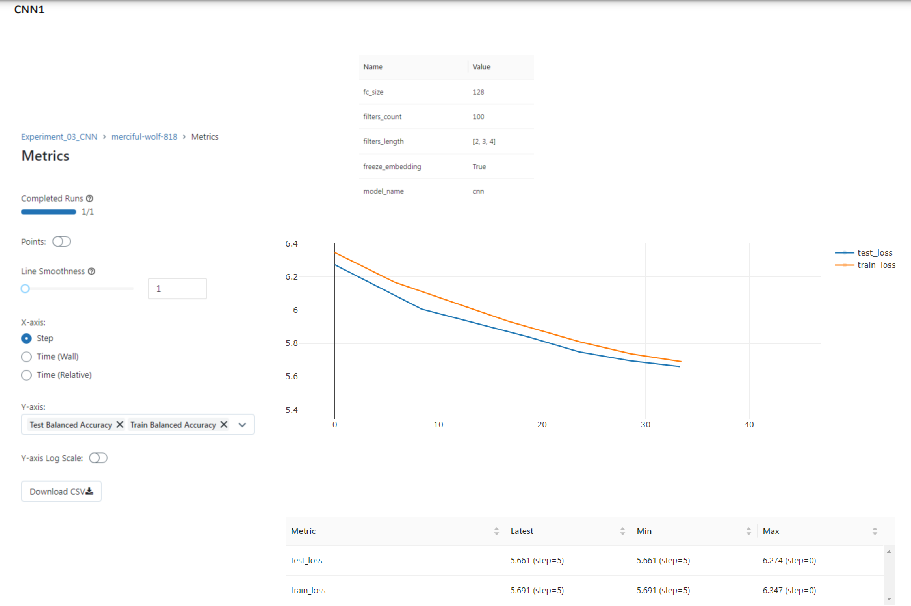

####Curva metrica (Balanced Accuracy)


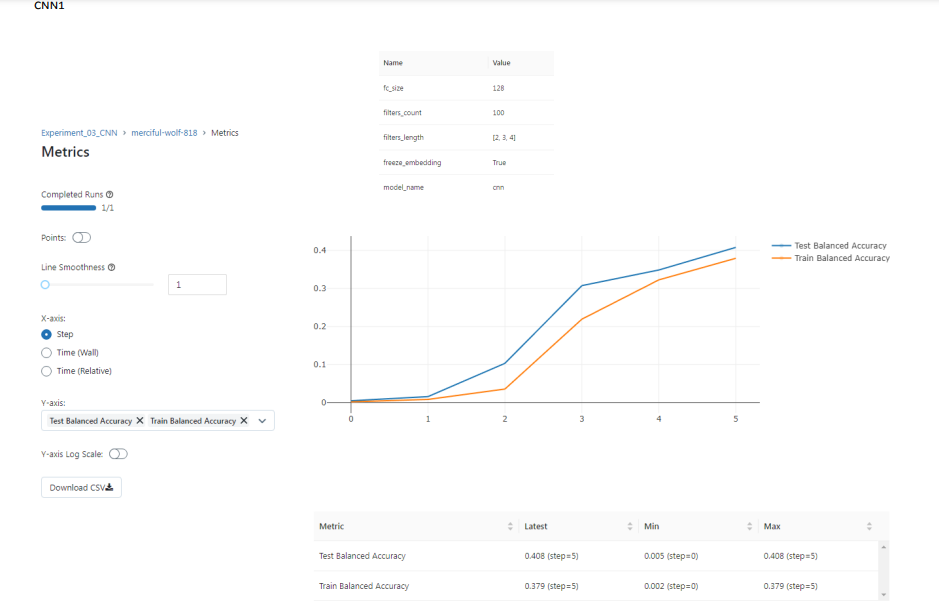

## Experimento de MLflow - MyCNN2

In [ ]:
class MyCNN2(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()
        
        self.embeddings = nn.Embedding(len(dictionary), 50, 0) 

        
        self.convs = []
        for filter_lenght in FILTERS_LENGTH:
            self.convs.append(
                nn.Conv1d(vector_size, FILTERS_COUNT, filter_lenght) #(in_channels, out_channels, kernel_size)
            )
        self.convs = nn.ModuleList(self.convs)
        self.fc = nn.Linear(FILTERS_COUNT * len(FILTERS_LENGTH), 256)
        self.output = nn.Linear(256, 632)
        self.vector_size = vector_size
        
    @staticmethod
    def conv_global_max_pool(x, conv):
        return F.relu(conv(x).transpose(1, 2).max(1)[0])
    
    def forward(self, x):
        x = self.embeddings(x).transpose(1, 2)  
        x = [self.conv_global_max_pool(x, conv) for conv in self.convs]
        x = torch.cat(x, dim=1)
        x = F.relu(self.fc(x))
        x = torch.sigmoid(self.output(x))
        return x

In [ ]:
mlflow.set_experiment("Experiment_04_CNN")
EPOCHS = 4
with mlflow.start_run():
    mlflow.log_param("model_name", "cnn")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "filters_count": FILTERS_COUNT,
        "filters_length": FILTERS_LENGTH,
        "fc_size": 256
    })
    model = MyCNN2("./data/glove.6B.50d.txt.gz", preprocess_train.dictionary, 50, True)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    for epoch in range(EPOCHS):
        model.to(device)
        running_loss = []
        y_true = []
        y_pred = []

        for idx, batch in enumerate(tqdm(train_loader)):
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            optimizer.zero_grad()
            inputs, labels = batch["data"], batch["target"]
            output = model(batch["data"])
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            loss_value = loss(output, batch["target"].squeeze().long())
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())        
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("Train Balanced Accuracy", balanced_accuracy_score(y_true, y_pred), epoch)

       
        model.eval()
        running_loss = []
        y_true = []
        y_pred = []
        targets = []
        predictions = []
        for idx, batch in enumerate(tqdm(train_loader)):
            inputs, labels = batch["data"], batch["target"]
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            output = model(batch["data"])
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            running_loss.append(
                loss(output, batch["target"].squeeze().long()).item()
            )
            targets.extend(batch["target"].cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        mlflow.log_metric("test_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("Test Balanced Accuracy", balanced_accuracy_score(y_true, y_pred), epoch)


    with tempfile.TemporaryDirectory() as tmpdirname:
        targets = []
        predictions = []
        for idx, batch in enumerate(tqdm(train_loader)):
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            output = model(batch["data"])
            targets.extend(batch["target"].cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(
            f"{tmpdirname}/predictions.csv.gz", index=False
        )
        mlflow.log_artifact(f"{tmpdirname}/predictions.csv.gz")
       

2022/10/05 18:04:47 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_04_CNN' does not exist. Creating a new experiment.


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

####Curva Loss

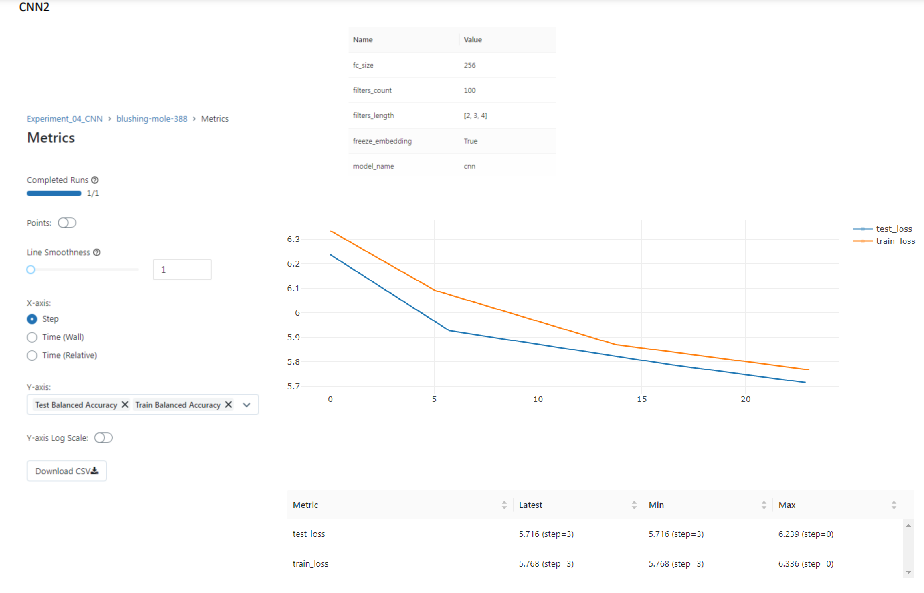

####Curva metrica (Balanced Accuracy)


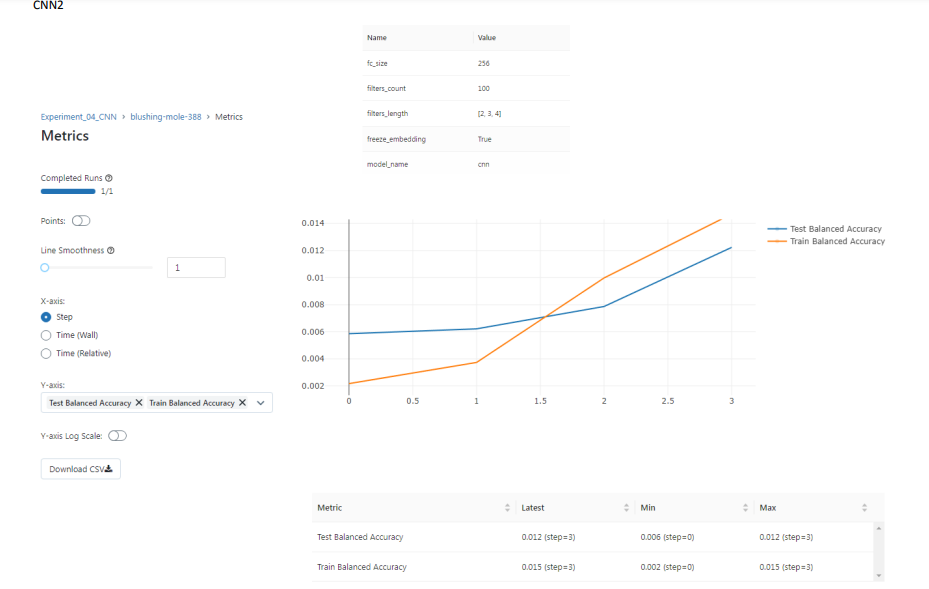

In [ ]:
# Zipeamos y bajamos la carpeta de experimentos MLRUNS
!zip -r /content/mlruns.zip /content/mlruns